# [Qubit Lattice Model](https://doi.org/10.1117/12.485960)
> _Venegas-Andraca SE, Bose S (2003)_ "Storing, processing, and retrieving an image using quantum mechanics" In: Quantum information and computation, vol 5105, pp 137–147. https://doi.org/10.1117/12.485960. International society for optics and photonics.

A naive algorithm that consists of literally copying the classical representation in quantum. Therefore, the circuit width is $2^{2n}$ for $2^{n} \times 2^{n}$ grayscale image. 

In order to encode RGB images, a lattice of qubits can be used, where each 'layer' holds the intensities of one color. The authors propose using a $R_{y}$ rotation gate to encode the pixel intensity. While this is the first formulation of quantum image storing, it has a major drawback of having large circuit width. This approach does not use quantum features like entanglement and superposition, and hence it has considerably low circuit depth.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.result.utils import marginal_distribution
from qiskit_ibm_runtime.fake_provider import FakeMumbai

import matplotlib.pyplot as plt
import numpy as np
import math

In [46]:
qc = QuantumCircuit(1)
qc.ry(np.pi/3, 0)

In [47]:
qc.draw()

┌─────────┐
q: ┤ Ry(π/3) ├
   └─────────┘

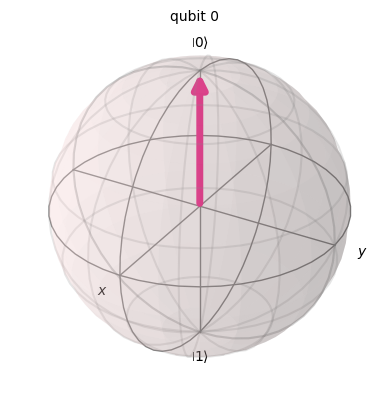

<IPython.core.display.Latex object>

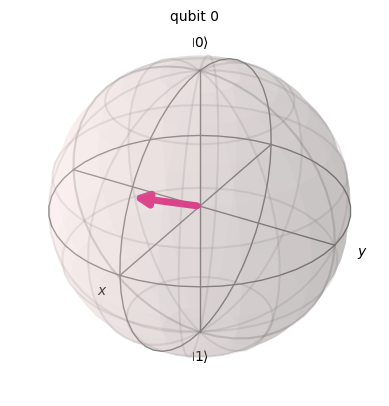

<IPython.core.display.Latex object>

In [48]:
zero = Statevector(np.array([1,0]))
display(plot_bloch_multivector(zero))
display(zero.draw('latex'))

output = zero.evolve(qc)
display(plot_bloch_multivector(output))
output.draw('latex')

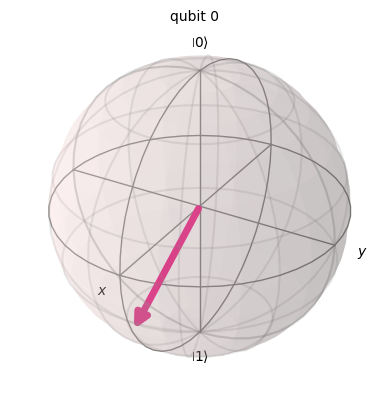

<IPython.core.display.Latex object>

In [41]:
qc.h(0)
output2 = zero.evolve(qc)
display(plot_bloch_multivector(output2))
output2.draw('latex')

In [234]:
qc2 = QuantumCircuit(1)
t = 1 * np.pi/3
qc2.ry(t, 0)

qc.h(0)
qc2.ry(-np.pi/2, 0)
qc2.rx(np.pi, 0)
qc2.ry((np.pi - t), 0)
# qc2.ry(-2*t, 0)
qc2.h(0)

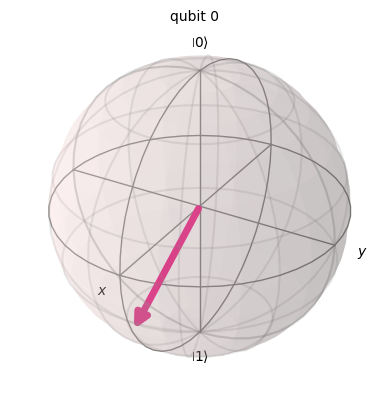

<IPython.core.display.Latex object>

In [235]:
output3 = zero.evolve(qc2)
display(plot_bloch_multivector(output3))
output3.draw('latex')


In [2]:
backend = AerSimulator()

In order to determine the angle of rotation based on the intensity, we use numpy's interpolation method. This will convert our input values from the range (0, 255) to (o, $\pi$).

Interpolation:
$$
y = y_{1} + (x - x_{1}) \frac{(y_{2} - y_{1})}{(x_{2} - x_{1})}
$$

where, $(x_{1}, y_{1}) = (0, 0)$, $(x_{2}, y_{2}) = (255, \pi)$

This will give us the angles $\in [o, \pi]$ for every input value between 0 and 255.


In [2]:
# INPUT
def getInput(n, linear=True, verbose=False):
    side = int(math.sqrt(n))
    if linear:
        input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)
    else:
        input_vector = []
        for i in range(side):
            input_vector.extend(np.linspace(start=i*side, stop=i*side+side, num=side, dtype=int) if not i%2 else np.linspace(start=i*side+side, stop=i*side, num=side, dtype=int))
    
    if verbose:
        plt.title('Input image')
        plt.imshow(np.reshape(input_vector, (side, side)), cmap='gray')

    input_angles = np.interp(input_vector, (0, 255), (0, np.pi))
    if verbose: print(input_vector,"\n", input_angles)

    return input_vector, input_angles

In [3]:
def prepareInput(n=4, input_range=(0, 255), angle_range=(0, np.pi/2), dist="linear", verbose=1):
    side = int(math.sqrt(n))
    if dist.lower() == "random":
        input_vector = np.random.uniform(low=0, high=255, size=n, dtype=int)
    
    elif dist.lower() == "reversing":
        input_vector = []
        init_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

        for i in range(side):
            input_vector.extend(init_vector[i*side:i*side+side] if not i%2 else init_vector[i*side+side-1:i*side-1:-1])
    else:
        input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

    input_angles = np.interp(input_vector, input_range, angle_range) 
    
    # if verbose: logger.debug(f'Inputs: size({n}), Vector: {input_vector}, Angles: {input_angles}')
    
    return input_vector, input_angles

In [12]:
prepareInput(9, verbose=True, dist="reversing")

[  0  31  63  95 127 159 191 223 255]
[0, 31, 63]
[0, 31, 63, 159, 127, 95]
[0, 31, 63, 159, 127, 95, 191, 223, 255]


([0, 31, 63, 159, 127, 95, 191, 223, 255],
 array([0.        , 0.19095955, 0.38807909, 0.97943771, 0.78231817,
        0.58519863, 1.17655725, 1.37367679, 1.57079633]))

In [2]:
# THRESHOLD
def getThresholdAngle(n=0.5, verbose=False):
    if verbose: print(f'{np.interp(n, (0, 255), (0, np.pi))}')
    return np.interp(n*255, (0, 255), (0, np.pi))

The encoder will simply apply the rotation gates to each qubit with appropriate angle.

$$
R_{y} = \begin{pmatrix}
cos \frac{\theta}{2} & - sin \frac{\theta}{2} \\
sin \frac{\theta}{2} & cos \frac{\theta}{2}
\end{pmatrix}
$$

In [29]:
# ENCODER
def qubitLatticeEncoder(qc: QuantumCircuit, angles: np.array, measure = False):
    q = QuantumRegister(len(angles), 'q')
    c = ClassicalRegister(len(angles), 'c')

    qc.add_register(q, c)

    for i, ang in enumerate(angles):
        qc.ry(ang, i)
    
    sv = Statevector(qc)
    
    if measure: qc.measure(reversed(range(len(angles))), range(len(angles)))
    else: qc.barrier()

    return sv

Adding a simple NOT gate on every qubit will invert the pixels value.

In [30]:
# INVERTER LOGIC
def invertPixels(qc: QuantumCircuit):
    for i in range(qc.num_qubits):
        qc.x(i)

    qc.barrier()

    return qc

In [31]:
# Measurements
def addMeasurements(qc: QuantumCircuit, verbose=False):
    qc.measure(reversed(range(qc.num_qubits)), range(qc.num_qubits))
    
    if verbose:
        print("Adding Measurments:")
        display(qc.draw())

    return qc

In [32]:
# SIMULATE
def simulate(qc: QuantumCircuit, shots = 1000000, verbose=False):
    t_qc_image = transpile(qc, backend)
    job = backend.run(t_qc_image, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if verbose:
        print(counts)
        display(plot_histogram(counts))
    
    return counts

[  0  31  63  95 127 159 191 223 255] 
 [0.         0.38191911 0.77615819 1.17039726 1.56463634 1.95887542
 2.3531145  2.74735358 3.14159265]
Statevector([1.37985458e-18+0.j, 0.00000000e+00+0.j, 2.66746679e-19+0.j,
             0.00000000e+00+0.j, 5.64100018e-19+0.j, 0.00000000e+00+0.j,
             1.09049032e-19+0.j, 0.00000000e+00+0.j, 9.14324805e-19+0.j,
             0.00000000e+00+0.j, 1.76752760e-19+0.j, 0.00000000e+00+0.j,
             3.73786228e-19+0.j, 0.00000000e+00+0.j, 7.22585093e-20+0.j,
             0.00000000e+00+0.j, 1.37138077e-18+0.j, 0.00000000e+00+0.j,
             2.65108564e-19+0.j, 0.00000000e+00+0.j, 5.60635829e-19+0.j,
             0.00000000e+00+0.j, 1.08379352e-19+0.j, 0.00000000e+00+0.j,
             9.08709853e-19+0.j, 0.00000000e+00+0.j, 1.75667305e-19+0.j,
             0.00000000e+00+0.j, 3.71490773e-19+0.j, 0.00000000e+00+0.j,
             7.18147633e-20+0.j, 0.00000000e+00+0.j, 2.05480706e-18+0.j,
             0.00000000e+00+0.j, 3.97225163e-19+0.j, 0.

┌───────┐    ░ 
q_0: ───┤ Ry(0) ├────░─
     ┌──┴───────┴──┐ ░ 
q_1: ┤ Ry(0.38192) ├─░─
     ├─────────────┤ ░ 
q_2: ┤ Ry(0.77616) ├─░─
     └┬────────────┤ ░ 
q_3: ─┤ Ry(1.1704) ├─░─
      ├────────────┤ ░ 
q_4: ─┤ Ry(1.5646) ├─░─
      ├────────────┤ ░ 
q_5: ─┤ Ry(1.9589) ├─░─
      ├────────────┤ ░ 
q_6: ─┤ Ry(2.3531) ├─░─
      ├────────────┤ ░ 
q_7: ─┤ Ry(2.7474) ├─░─
      └─┬───────┬──┘ ░ 
q_8: ───┤ Ry(π) ├────░─
        └───────┘    ░ 
c: 9/══════════════════

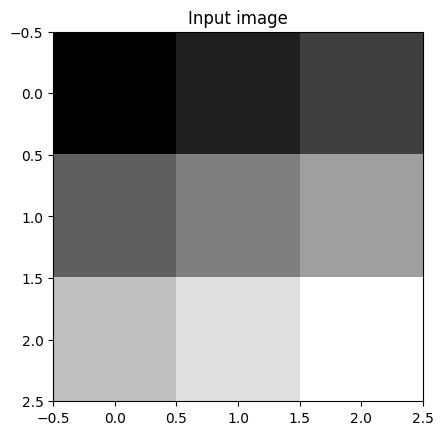

In [34]:
# Setup basic circuit:
circuit = QuantumCircuit()
input_vector, input_angles = getInput(n = 9, verbose=True)

ql_StateVec = qubitLatticeEncoder(circuit, angles=input_angles, measure=False)

print(f"{ql_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

<IPython.core.display.Latex object>

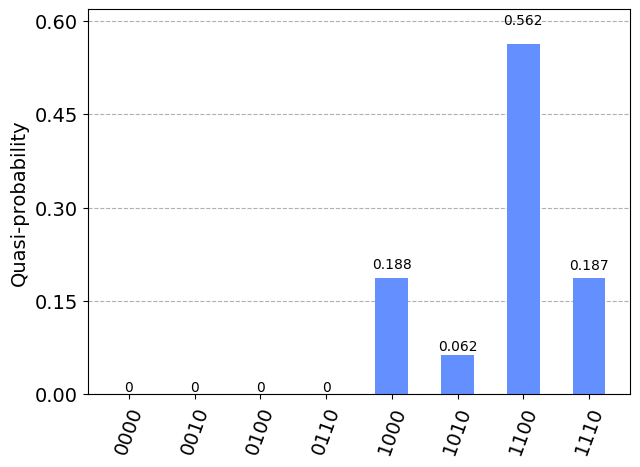

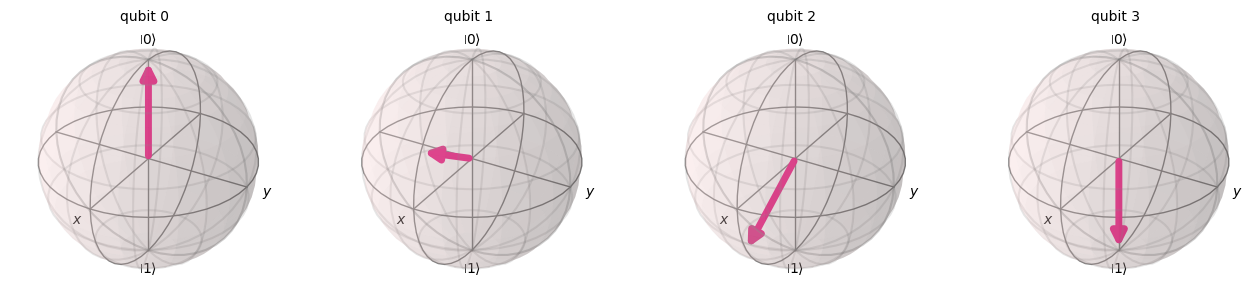

In [10]:
display(ql_StateVec.draw('latex'))

display(plot_distribution(ql_StateVec.probabilities_dict()))

display(plot_bloch_multivector(ql_StateVec))
# circuit.measure(reversed(range(len(input_vector))), range(len(input_vector)))

In [48]:
threshTheta = np.pi/2 + getThresholdAngle(n = 0.25, verbose=True)

for i in range(circuit.num_qubits):
    circuit.ry(threshTheta, i)

circuit.barrier()
display(circuit.draw())

0.003079992797637052


┌───────┐   ░ ┌───┐ ░ ┌──────────┐ ░ 
q_0: ─┤ Ry(0) ├───░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     ┌┴───────┴┐  ░ ├───┤ ░ ├──────────┤ ░ 
q_1: ┤ Ry(π/3) ├──░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     ├─────────┴┐ ░ ├───┤ ░ ├──────────┤ ░ 
q_2: ┤ Ry(2π/3) ├─░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
     └┬───────┬─┘ ░ ├───┤ ░ ├──────────┤ ░ 
q_3: ─┤ Ry(π) ├───░─┤ Y ├─░─┤ Ry(3π/4) ├─░─
      └───────┘   ░ └───┘ ░ └──────────┘ ░ 
c: 4/══════════════════════════════════════

<IPython.core.display.Latex object>

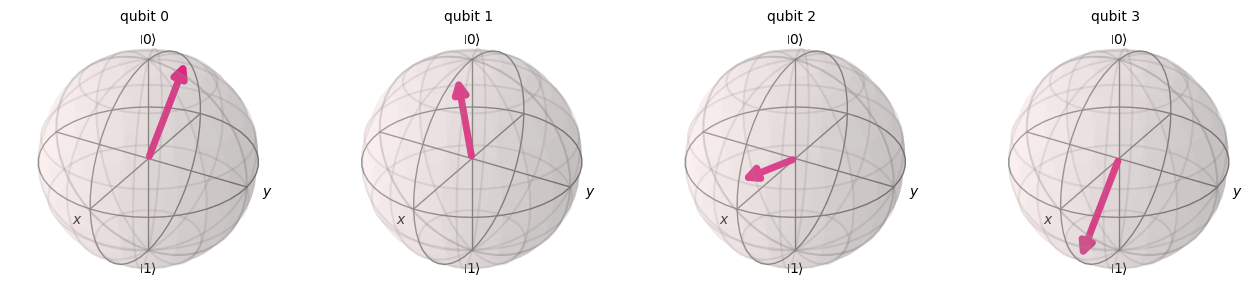

In [49]:
display(Statevector(circuit).draw('latex'))
plot_bloch_multivector(Statevector(circuit))

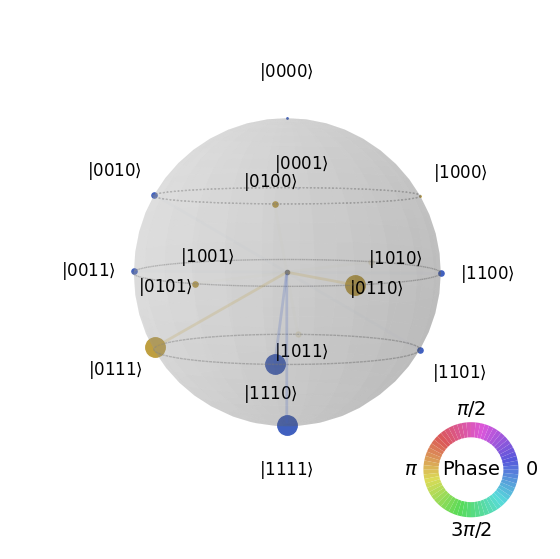

In [47]:
plot_state_qsphere(Statevector(circuit))

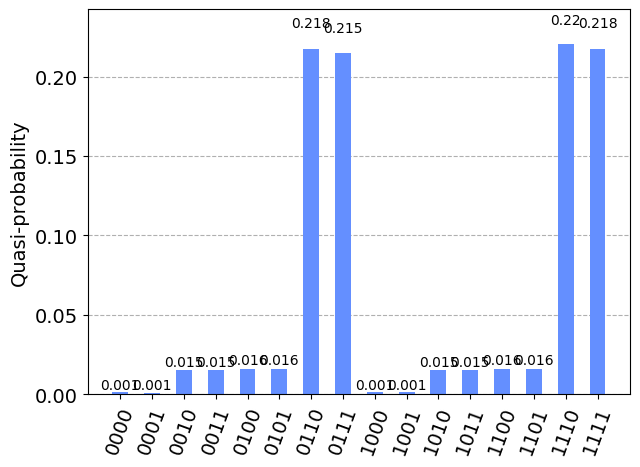

In [19]:
plot_distribution(Statevector(circuit).probabilities_dict())

Decoding is a complex process which is done classically after measurements. Initially, for each qubit, we will find the total count where that qubit has value '0'.

In [35]:
invertPixels(qc = circuit)
addMeasurements(qc = circuit)

In [78]:
''' Noisy model from AER: https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.NoiseModel.html '''
# # Get a fake backend from the fake provider
# backend = FakeMumbai()
# noise_model = NoiseModel.from_backend(backend)

# # Get coupling map from backend
# coupling_map = backend.configuration().coupling_map

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# backend = AerSimulator(noise_model=noise_model,
#                        coupling_map=coupling_map,
#                        basis_gates=basis_gates)

''' Noisy model from QiskitRuntimeService: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/fake_provider '''
service = QiskitRuntimeService(channel="ibm_quantum", token="b58f04be6f1a8412295c8b59c3e19af21d1c9501d28ca176687d5c3f49338f0211c08461348a978c07dcecc76de10675f84deb366634b56c3a8ac0514085be5c")
backend = service.get_backend('ibm_brisbane')
backend = AerSimulator.from_backend(backend)

''' Pure simulator '''
# backend = AerSimulator()


' Pure simulator '

{'111101000': 720, '111011100': 53, '111100000': 1595, '111101100': 116, '111010000': 705, '111100100': 278, '111110000': 1590, '101101100': 2, '111000000': 695, '111001000': 324, '111011010': 24, '111100010': 63, '100011100': 1, '100000000': 4, '111111000': 750, '111011000': 330, '110111100': 26, '110100000': 269, '111111010': 28, '110001100': 8, '110010000': 119, '110101000': 126, '101010000': 22, '111010100': 143, '101100000': 56, '111001100': 54, '110001000': 66, '110110000': 267, '111000100': 122, '100100000': 7, '110011110': 3, '111110100': 303, '101110000': 57, '100110000': 11, '110001010': 5, '110010010': 7, '111111100': 130, '110110100': 53, '110011100': 14, '111110010': 72, '110000000': 119, '100110100': 1, '101111000': 30, '110110010': 10, '101000000': 32, '110111000': 129, '100010000': 4, '110011000': 64, '110010100': 22, '101111010': 2, '111110110': 6, '110000100': 28, '101101000': 27, '111000010': 21, '110100100': 47, '101100010': 1, '100101000': 5, '110100010': 6, '11011

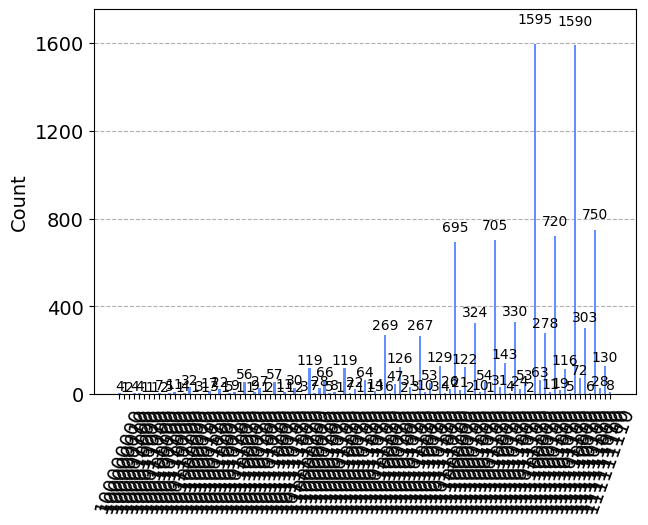

In [36]:
shots = 10000
counts = simulate(qc = circuit, verbose=True, shots=shots)

# pure: {'0011': 562583, '0111': 187925, '0001': 187182, '0101': 62310}


In [37]:
for  iq in range(len(input_vector)):
    marCnt=marginal_distribution(counts,[iq])
    print('iq:',iq,marCnt)

iq: 0 {'0': 10000}
iq: 1 {'0': 9628, '1': 372}
iq: 2 {'0': 8478, '1': 1522}
iq: 3 {'0': 6833, '1': 3167}
iq: 4 {'0': 4932, '1': 5068}
iq: 5 {'0': 3099, '1': 6901}
iq: 6 {'0': 1489, '1': 8511}
iq: 7 {'0': 344, '1': 9656}
iq: 8 {'1': 10000}


In [38]:
# DECODE
output_values = np.zeros((len(input_vector)))

for item in counts:    
    print(item, counts[item])
    for i, bit in enumerate(item):
        if bit == '0':
            output_values[i] += counts[item]

print("q0, q1, q2, q3 : ", output_values)

111101000 720
111011100 53
111100000 1595
111101100 116
111010000 705
111100100 278
111110000 1590
101101100 2
111000000 695
111001000 324
111011010 24
111100010 63
100011100 1
100000000 4
111111000 750
111011000 330
110111100 26
110100000 269
111111010 28
110001100 8
110010000 119
110101000 126
101010000 22
111010100 143
101100000 56
111001100 54
110001000 66
110110000 267
111000100 122
100100000 7
110011110 3
111110100 303
101110000 57
100110000 11
110001010 5
110010010 7
111111100 130
110110100 53
110011100 14
111110010 72
110000000 119
100110100 1
101111000 30
110110010 10
101000000 32
110111000 129
100010000 4
110011000 64
110010100 22
101111010 2
111110110 6
110000100 28
101101000 27
111000010 21
110100100 47
101100010 1
100101000 5
110100010 6
110110110 3
101001000 17
101011000 9
110101100 31
111010010 31
101110100 11
111100110 11
101001100 3
101111100 3
111001010 10
111101110 5
110001110 1
100001000 4
110000010 7
111101010 19
110101110 3
111111110 8
110101010 2
100111000 4
1001

Steps for reconstruction:
1. Find the _value / shots_ ratio
2. Take the square root of this ratio
3. Calculate _arccos_ and double the value

$$
output = 2 \times \arccos{(\sqrt{\frac{value}{shots}})}
$$
This ratio $value/shots$ is essentially the the conditional probability of observing a state given that the qubit associated selected pixel is in state $|0\rangle$.

4. Interpolate back from (0, $\pi$) to (0, 255)


In [39]:
# RECONSTRUCT
for i, value in enumerate(output_values):
    print(f"\nFor pixel {i}:")
    print(f"\tvalue/shots = {value}/{shots} = {value/shots}")
    print(f"\tsqrt(value/shots) = {(value/shots)**(1/2)}")
    print(f"\tarccos = {np.arccos((value/shots)**(1/2))}")
    print(f"\t2 * arccos = {2*np.arccos((value/shots)**(1/2))}")

# step 1,2,3
reconstruct = [2*np.arccos((value/shots)**(1/2)) for value in output_values]

# step 4
reconstruct = np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int)

print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {reconstruct}")


For pixel 0:
	value/shots = 0.0/10000 = 0.0
	sqrt(value/shots) = 0.0
	arccos = 1.5707963267948966
	2 * arccos = 3.141592653589793

For pixel 1:
	value/shots = 344.0/10000 = 0.0344
	sqrt(value/shots) = 0.1854723699099141
	arccos = 1.384243775764617
	2 * arccos = 2.768487551529234

For pixel 2:
	value/shots = 1489.0/10000 = 0.1489
	sqrt(value/shots) = 0.38587562763149474
	arccos = 1.1746395548603292
	2 * arccos = 2.3492791097206585

For pixel 3:
	value/shots = 3099.0/10000 = 0.3099
	sqrt(value/shots) = 0.5566866263886712
	arccos = 0.9804044261248693
	2 * arccos = 1.9608088522497387

For pixel 4:
	value/shots = 4932.0/10000 = 0.4932
	sqrt(value/shots) = 0.7022819946431775
	arccos = 0.7921983730362308
	2 * arccos = 1.5843967460724615

For pixel 5:
	value/shots = 6833.0/10000 = 0.6833
	sqrt(value/shots) = 0.8266196223173026
	arccos = 0.5977221876192432
	2 * arccos = 1.1954443752384865

For pixel 6:
	value/shots = 8478.0/10000 = 0.8478
	sqrt(value/shots) = 0.9207605551933684
	arccos = 0.400

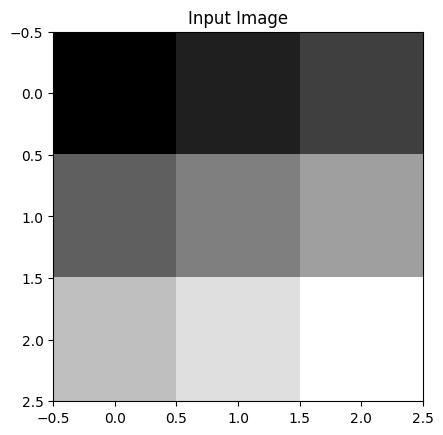

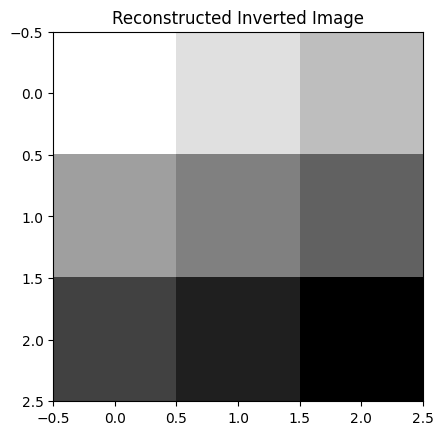

In [42]:
def plot_to_compare(input_vector, reconstruct):
    plt.imshow(np.reshape(input_vector, (3, 3)), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(reconstruct, (3, 3)), cmap = 'gray')
    plt.title('Reconstructed Inverted Image')
    plt.show()

plot_to_compare(input_vector, reconstruct)

The Qubit Lattice model served as a base model for quantum encoding for image processing. Several other models like SQR and FRQI are based on this model.